In [25]:
import pandas as pd
import numpy as np
import pickle
from surprise import Reader, Dataset, SVD
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [26]:
def load_data():
    reviews = pd.read_pickle("../Pickle/reviews.pkl")
    interactions = pd.read_pickle("../Pickle/interactions.pkl")
    read = pd.read_pickle("../Pickle/read.pkl")
    return reviews, interactions, read

In [27]:
def preprocess_data(df):
    users_with_only_zeros = df.groupby('user_id')['rating'].apply(lambda x: (x == 0).all())
    users_with_only_zeros = users_with_only_zeros[users_with_only_zeros].index
    df = df[~df['user_id'].isin(users_with_only_zeros)]
    
    rated_books = df[df['is_read'] != 0].reset_index(drop = True)
    rated_books = rated_books[rated_books['rating'] != 0].reset_index(drop=True)
    return rated_books

In [28]:
def split_data(df):
    user_counts = df['user_id'].value_counts()
    book_counts = df['book_id'].value_counts()
    
    single_interactions = df[df['user_id'].isin(user_counts[user_counts == 1].index) |
                             df['book_id'].isin(book_counts[book_counts == 1].index)]
    remaining_interactions = df[~df.index.isin(single_interactions.index)]
    
    train_df, test_df = train_test_split(remaining_interactions, test_size=0.2, random_state=42, stratify=remaining_interactions['rating'])
    train_df = pd.concat([train_df, single_interactions], ignore_index=True)
    
    return train_df, test_df

In [29]:
def upsample_ratings(train_df):
    rating_counts = train_df['rating'].value_counts()
    max_count = rating_counts.max()

    modified_dfs = []
    
    for rating, count in rating_counts.items():
        class_df = train_df[train_df['rating'] == rating]
        num_extra = max_count - count

        if num_extra > 0:
            extra_samples = class_df.sample(num_extra, replace=True, random_state=42)
            extra_samples['rating'] += np.random.uniform(-0.1, 0.1, size=len(extra_samples))
            extra_samples['rating'] = extra_samples['rating'].clip(1, 5)

            modified_dfs.append(extra_samples)
    
    return pd.concat([train_df] + modified_dfs, ignore_index=True)

In [30]:
def normalize_ratings(train_df, test_df):
    min_rating = train_df['rating'].min()
    
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    train_df['rating'] = np.log1p(train_df['rating'] - min_rating)
    test_df['rating'] = np.log1p(test_df['rating'] - min_rating)
    
    return train_df, test_df, min_rating

def denormalize_rating(log_scaled_ratings, min_rating):
    original_ratings = np.expm1(np.asarray(log_scaled_ratings, dtype=float))
    return np.clip(original_ratings + min_rating, 1, 5) 


In [31]:
reviews, interactions, read = load_data()

KeyboardInterrupt: 

In [ ]:
df = read[read['is_read'] == 1].reset_index(drop = True)
df_zeros = df[df['rating'] == 0].reset_index(drop = True)

In [ ]:
reviews_0 = reviews[reviews['rating'] == 0]
inter_0 = interactions[interactions['rating'] == 0]
user_reviews = reviews_0['user_id'].unique()
user_inter = inter_0['user_id'].unique()

In [ ]:
inference = pd.concat([reviews_0, inter_0], ignore_index=True)

In [ ]:
seen = set()  
res = [x for x in list(user_reviews) + list(user_inter) if x not in seen and not seen.add(x)]
df = df[df['user_id'].isin(res)]

In [ ]:
len(df)

2432440

In [ ]:
df['user_id'].nunique()

6781

In [ ]:
df = df.astype(np.int32)

In [ ]:
df = preprocess_data(df)

In [ ]:
train_df, test_df = split_data(df)

In [ ]:
train_df = upsample_ratings(train_df)

In [ ]:
train_df, test_df, min_rating = normalize_ratings(train_df, test_df)

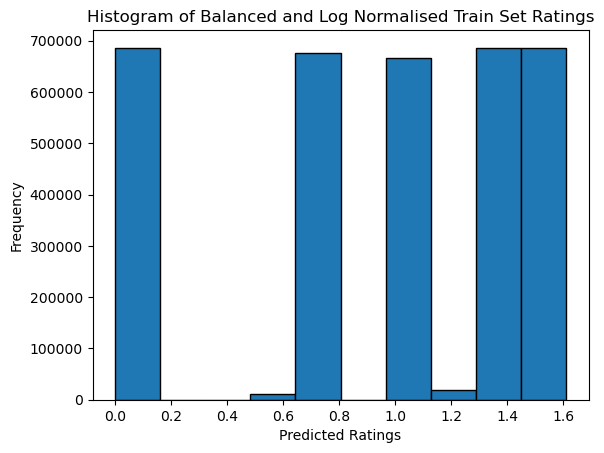

In [ ]:
plt.hist(train_df['rating'], bins=10, edgecolor='black')
plt.title('Histogram of Balanced and Log Normalised Train Set Ratings')
plt.xlabel('Predicted Ratings')
plt.ylabel('Frequency')
plt.show()

In [ ]:
reader = Reader(rating_scale=(1, 5))

In [ ]:
train_data = Dataset.load_from_df(train_df[['user_id', 'book_id', 'rating']], reader)

In [ ]:
param_grid = {
    'n_factors': [100, 200, 300],
    'n_epochs': [100, 200, 300],
    'lr_all': [0.001, 0.1],
    'reg_all': [0.001, 0.1]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=2, n_jobs=-1)

gs.fit(train_data)

best_params = gs.best_params['rmse']  
best_model = gs.best_estimator['rmse']  

print(f"Best RMSE: {gs.best_score['rmse']:.4f}")
print(f"Best Parameters: {best_params}")

Best RMSE: 0.4962
Best Parameters: {'n_factors': 300, 'n_epochs': 300, 'lr_all': 0.001, 'reg_all': 0.001}


In [33]:
trainset = train_data.build_full_trainset()

In [34]:
from surprise import accuracy

best_model = SVD(**best_params, verbose=True)
best_model.fit(trainset)

testset = [tuple(x) for x in test_df[['user_id', 'book_id', 'rating']].values]
predictions = best_model.test(testset)

test_rmse = accuracy.rmse(predictions)
test_mae = accuracy.mae(predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

In [35]:
predictions = best_model.test(testset)

In [36]:
from collections import defaultdict
import numpy as np
from math import log2


def precision_recall_ndcg_mrr_at_k(predictions, min_rating, k, threshold):
    denormalized_ratings = [denormalize_rating(est, min_rating) for _, _, _, est, _ in predictions]
    denormalized_true_ratings = [denormalize_rating(true_r, min_rating) for _, _, true_r, _, _ in predictions]

    denormalized_predictions = [(uid, iid, denormalized_true_ratings[idx], denormalized_ratings[idx], _) 
                                for idx, (uid, iid, true_r, est, _) in enumerate(predictions)]

    # Organise predictions by user
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in denormalized_predictions:
        user_est_true[uid].append((iid, est, true_r))

    precisions, recalls, ndcgs, mrrs = [], [], [], []

    for user_id, user_ratings in user_est_true.items():
        # Sort by estimated rating
        user_ratings.sort(key=lambda x: x[1], reverse=True)

        # Get relevant items (ratings >= threshold)
        relevant_items = [(iid, est, true_r) for iid, est, true_r in user_ratings if true_r >= threshold]
        n_rel = len(relevant_items)

        if n_rel == 0:
            precisions.append(0)
            recalls.append(0)
            ndcgs.append(0)
            mrrs.append(0)
            continue

        # Get top-k predictions
        top_k = user_ratings[:k]
        n_rec_k = sum(est >= threshold for _, est, _ in top_k)
        n_rel_and_rec_k = sum((true_r >= threshold) and (est >= threshold) for _, est, true_r in top_k)

        # Precision at k
        precision = n_rel_and_rec_k / n_rec_k if n_rec_k > 0 else 0
        recall = n_rel_and_rec_k / n_rel if n_rel > 0 else 0

        # NDCG at k
        actual_dcg = sum((2 ** rel - 1) / log2(idx + 2) for idx, (_, _, rel) in enumerate(top_k))
        ideal_ratings_sorted = sorted(user_ratings, key=lambda x: x[2], reverse=True)[:k]
        ideal_dcg = sum((2 ** rel - 1) / log2(idx + 2) for idx, (_, _, rel) in enumerate(ideal_ratings_sorted))
        ndcg = actual_dcg / ideal_dcg if ideal_dcg > 0 else 0

        # MRR at k
        mrr = 0
        for rank, (iid, est, true_r) in enumerate(top_k, start=1):
            if true_r >= threshold:
                mrr = 1 / rank
                break

        # Append the metrics
        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)
        mrrs.append(mrr)

    return (
        np.mean(precisions),
        np.mean(recalls),
        np.mean(ndcgs),
        np.mean(mrrs)
    )


k = 5
precisions, recalls, ndcgs, mrrs = precision_recall_ndcg_mrr_at_k(predictions, min_rating, k, 4)
print(f'Precision@{k}: {precisions:.4f}, Recall@{k}: {recalls:.4f}, nDCG@{k}: {ndcgs:.4f}, MRR@@{k}: {mrrs:.4f} ')

Precision@5: 0.7589, Recall@5: 0.1773, nDCG@5: 0.6717, MRR@@5: 0.8758 


In [37]:
import pickle
with open("../Pickle/best_svd_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [38]:
import pickle
with open("../Pickle/best_svd_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [39]:
trainset = loaded_model.trainset

def predict_with_fallback(user_id, book_id):
    if not trainset.knows_user(user_id):
        return np.nan  # User not in training
    if not trainset.knows_item(book_id):
        return np.nan  # Book not in training
    
    pred = loaded_model.predict(user_id, book_id)
    return pred.est  # Return estimated rating

inference["predicted_rating"] = inference.apply(
    lambda row: predict_with_fallback(row["user_id"], row["book_id"]), axis=1
)

In [40]:
inference.loc[inference["predicted_rating"].notna(), "predicted_rating"] = inference["predicted_rating"].apply(
    lambda x: denormalize_rating(x, min_rating) if pd.notna(x) else x)

In [41]:
inference = inference.dropna(subset=['predicted_rating'])

In [42]:
inference = inference.reset_index(drop = True)

In [43]:
inference = inference[['user_id', 'book_id', 'predicted_rating']]
inference = inference.rename(columns={"predicted_rating": "rating"})

In [44]:
inference['rating'] = inference['rating'].apply(lambda x: round(x, 0))

In [45]:
inference

,user_id,book_id,rating
0,0,70,4.0
1,0,105,4.0
2,0,108,3.0
3,0,171,4.0
4,0,178,3.0
...,...,...,...
37463,1972,87775,5.0
37464,1972,17400,5.0
37465,1972,58820,5.0
37466,1972,21104,3.0


In [46]:
with open('../Pickle/imputed_ratings.pkl', 'wb') as f:
    pickle.dump(inference, f)